In [1]:
from dqn.agent import CarRacingDQN
import os
import tensorflow as tf
import gym
import _thread
import re
import sys
import numpy as np
from matplotlib import pyplot as plt

import h5py
import pickle
import glob as glob

from car_racing_ellipse import CarRacingEllipse
from car_racing_square import CarRacingSquare
from car_racing_zigzag import CarRacingZigZag
from car_racing_cycle_tracks import CarRacingCycleTracks

from gym.wrappers.monitoring import Monitor

from sklearn.tree import DecisionTreeClassifier
from CarRacingHDT import CarRacingHDT

from skimage import color, transform
import itertools as it

model_config = dict(
    min_epsilon=0.1,
    max_negative_rewards=12,
    min_experience_size=int(1e4),
    num_frame_stack=1,
    frame_skip=3,
    train_freq=4,
    batchsize=64,
    epsilon_decay_steps=int(1e5),
    network_update_freq=int(1e3),
    experience_capacity=int(4e4),
    gamma=0.95
)

record_video = False

track_type = 'ZigZag'

if track_type=='Square':
    env = CarRacingSquare()
elif track_type=='Ellipse':
    env = CarRacingEllipse()
elif track_type=='ZigZag':
    env = CarRacingZigZag()
elif track_type=='Cycle':
    env = CarRacingCycleTracks()

dqn_agent = CarRacingDQN(env=env, **model_config)
dqn_agent.build_graph()
sess = tf.InteractiveSession()
dqn_agent.session = sess

saver = tf.train.Saver(max_to_keep=100)

if track_type == 'Square':
    checkpoint_path = "data/square_20210608"
elif track_type == 'Ellipse':
    checkpoint_path = "data/ellipse_20210608"
elif track_type == 'ZigZag':
    checkpoint_path = 'data/zigzag_20210608'


print("loading the latest checkpoint from %s" % checkpoint_path)
ckpt = tf.train.get_checkpoint_state(checkpoint_path)
assert ckpt, "checkpoint path %s not found" % checkpoint_path
global_counter = int(re.findall("-(\d+)$", ckpt.model_checkpoint_path)[0])
saver.restore(sess, ckpt.model_checkpoint_path)
#dqn_agent.global_counter = global_counter

dqn_agent.do_training = False
dqn_agent.do_rollouts = True

save_freq_episodes = 5

print(dqn_agent.get_epsilon())
print(dqn_agent.global_counter)

tree_folder = sorted(glob.glob(os.path.join('data/Combine/Students/HDT','*','')),key=os.path.getmtime)[-1]
video_path = os.path.join(tree_folder,'Videos')

if record_video:
    env = Monitor(env, video_path, force=True)
# save_path = 'data/square/hard_trees_frames_48664_train_points/'
test_episodes = 3
min_depth = 19
#max_depth = 10
max_depth = 20
max_neg_rewards=12

def process_image(obs):
    return 2 * color.rgb2gray(obs) - 1.0

all_actions = np.array(
            [k for k in it.product([-1, 0, 1], [1, 0], [0.2, 0])]
        )
action_map=all_actions

def check_early_stop(reward, totalreward):
    if reward < 0:
        neg_reward_counter += 1

def check_early_stop(reward, totalreward):
    if reward < 0:
        neg_reward_counter += 1
        done = (self.neg_reward_counter > self.max_neg_rewards)

        if done and totalreward <= 500:
            punishment = -20.0
        else:
            punishment = 0.0  
        if done:
            self.neg_reward_counter = 0

        return done, punishment
    else:
        self.neg_reward_counter = 0
        return False, 0.0

/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

In [2]:
depth = min_depth

#depth = 12
student = pickle.load(open(tree_folder+'hard_tree_depth_'+str(depth)+'_balanced.pkl','rb'))

student = CarRacingHDT(student,max_negative_rewards=max_neg_rewards)

    #env_name = "CarRacing-v0"
    #env = gym.make(env_name)

frame_skip = 3
render = 1

total_reward = 0
frames_in_episode = 0
obs = env.reset()
#print(env.stats_recorder.done)
#plt.figure()
#plt.imshow(process_image(obs))

acts = []

while True:
    obs_pp = process_image(obs)
    #obs_pp = obs_pp.reshape((1,-1))
    obs_pp = obs_pp.reshape((1,-1))
#action_idx = student.predict(obs_pp).argmax(axis=1)[0]
    action_idx = student.tree.predict(obs_pp)[0]
    action = action_map[action_idx]
    acts.append(action_idx)
    #print(action_idx)
    #print(action)

    reward = 0
    for _ in range(frame_skip):
        obs, r, done, info = env.step(action)
        if render:
            env.render()
        reward += r
        if done:
            break
    
    early_done, punishment = student.check_early_stop(reward, total_reward)
    if early_done:
        #env.stats_recorder.done = True
        #env.stats_recorder.save_complete()
        print('EARLY DONE')
        reward += punishment

    done = done or early_done

    total_reward += reward
    frames_in_episode += 1

    if done:
        print('frames in episode: '+str(frames_in_episode))
        print('total reward: '+str(total_reward))
        break

Track generation: 1340..1781 -> 441-tiles track
EARLY DONE
frames in episode: 34
total reward: -5.256689342403654


In [3]:
dqn_rewards = []
for ep in range(0,test_episodes)
dqn_reward, frames_in_episode, actions, frames = dqn_agent.play_episode()

Track generation: 1340..1781 -> 441-tiles track


In [4]:
for depth in range(min_depth,max_depth+1):
#for depth in range(min_depth,min_depth+1):

    #depth = 12
    student = pickle.load(open(tree_folder+'hard_tree_depth_'+str(depth)+'_balanced.pkl','rb'))

    student = CarRacingHDT(student,max_negative_rewards=max_neg_rewards)

    #env_name = "CarRacing-v0"
    #env = gym.make(env_name)

    frame_skip = 3
    render = 1

    ep_rewards = []
    ep_actions = []
    episode_counter = 0

    for ep in range(0,test_episodes):

        print('Depth: '+str(depth))
        print('Episode: '+str(episode_counter+1))
        episode_counter+=1
        total_reward = 0
        frames_in_episode = 0
        obs = env.reset()
        #print(env.stats_recorder.done)
        #plt.figure()
        #plt.imshow(process_image(obs))

        acts = []

        while True:
            obs_pp = process_image(obs)
            #obs_pp = obs_pp.reshape((1,-1))
            obs_pp = obs_pp.reshape((1,-1))
        #action_idx = student.predict(obs_pp).argmax(axis=1)[0]
            action_idx = student.tree.predict(obs_pp)[0]
            action = action_map[action_idx]
            acts.append(action_idx)
            #print(action_idx)
            #print(action)

            reward = 0
            for _ in range(frame_skip):
                obs, r, done, info = env.step(action)
                if render:
                    env.render()
                reward += r
                if done:
                    break
            
            early_done, punishment = student.check_early_stop(reward, total_reward)
            if early_done:
                #env.stats_recorder.done = True
                #env.stats_recorder.save_complete()
                #print('EARLY DONE')
                reward += punishment

            done = done or early_done

            total_reward += reward
            frames_in_episode += 1

            if done:
                print('frames in episode: '+str(frames_in_episode))
                print('total reward: '+str(total_reward))
                break

        ep_rewards.append(total_reward)
        ep_actions.append(acts)

    #f = h5py.File(save_path+'hard_tree_depth_'+str(depth)+'balanced_rewards_'+str(test_episodes)+'.h5','w')
    f = h5py.File(tree_folder+'/'+track_type+'/hard_tree_depth_'+str(depth)+'_balanced_rewards_'+str(test_episodes)+'.h5','w')
    f.create_dataset('ep_rewards',data=ep_rewards)
    #f.create_dataset('ep_actions',data=ep_actions)
    f.close()

env.close()

Depth: 19
Episode: 1
Track generation: 1340..1781 -> 441-tiles track
frames in episode: 54
total reward: 6.883900226757234
Depth: 20
Episode: 1
Track generation: 1340..1781 -> 441-tiles track
frames in episode: 34
total reward: -5.25668934240365


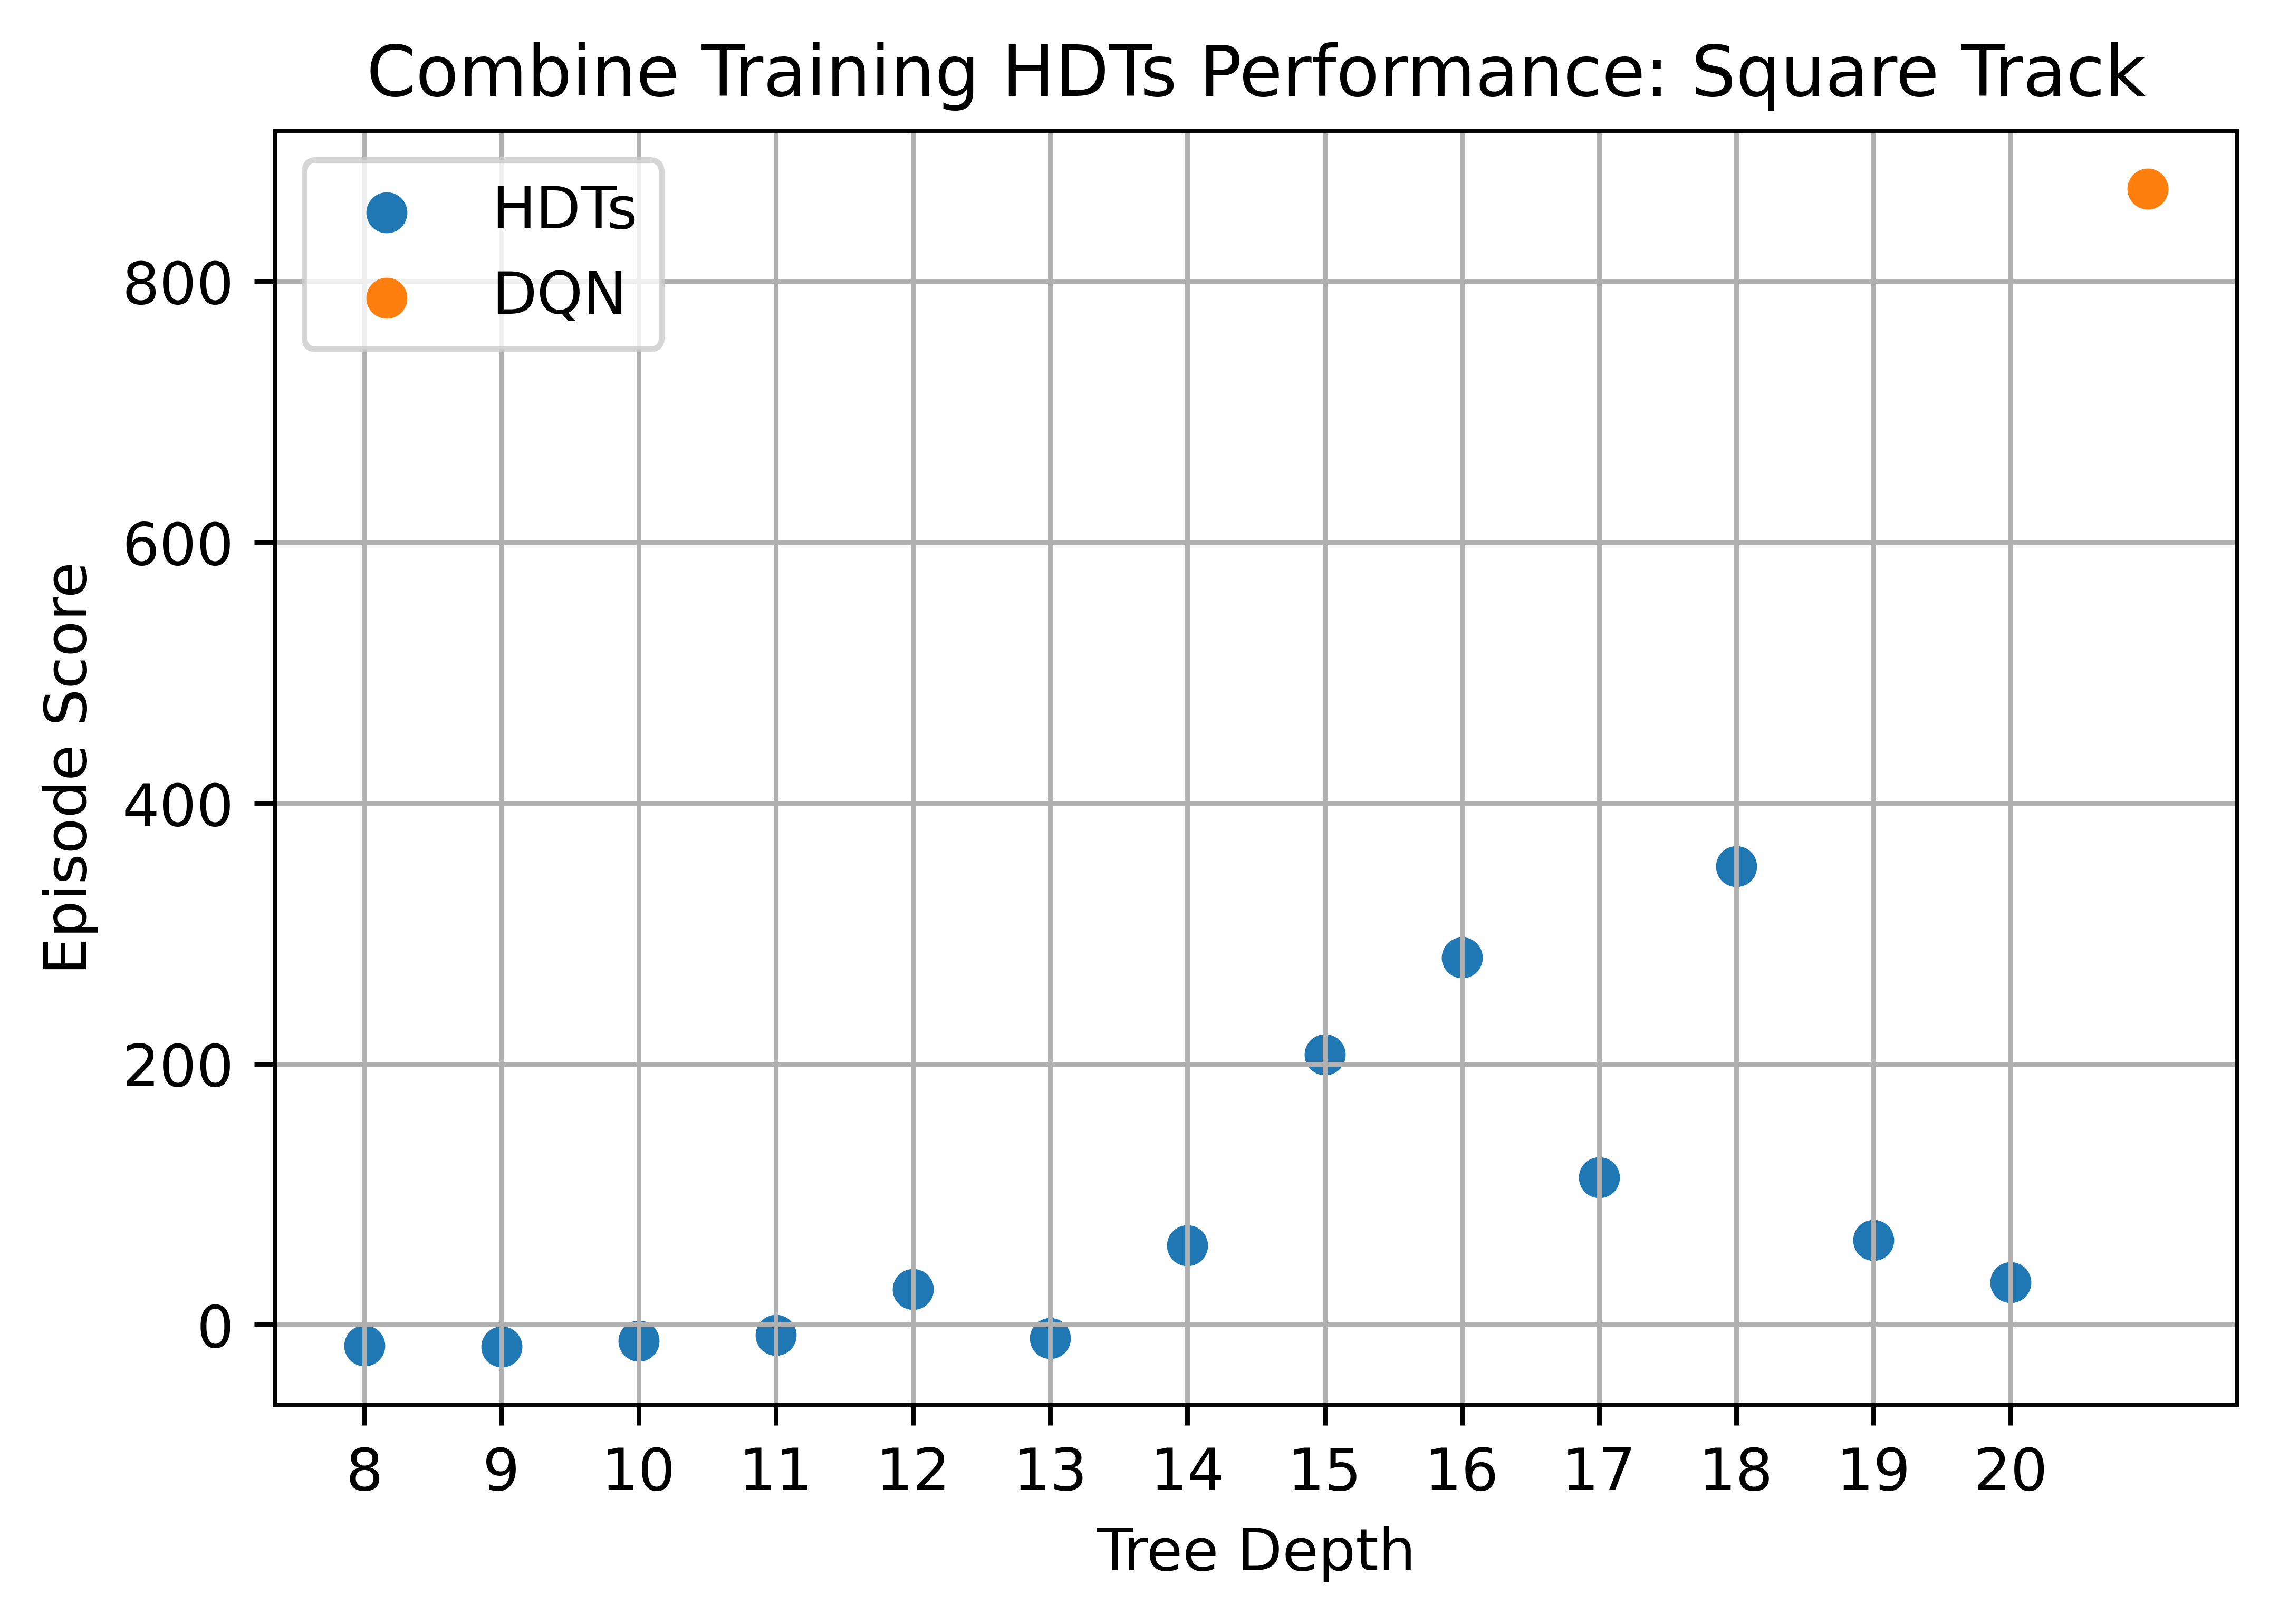

In [6]:
hdt_reward_files = sorted(glob.glob(os.path.join(tree_folder,track_type,'*rewards*')),key=os.path.getmtime)

rewards = []

for rew_file in hdt_reward_files:
    with h5py.File(rew_file,'r') as f:
        rewards.append(f['ep_rewards'][:])

plt.figure(dpi=800)
tree_depths = np.array(range(min_depth,max_depth+1))
plt.scatter(tree_depths,rewards,label='HDTs')
plt.scatter(tree_depths[-1]+1,dqn_reward,label='DQN')
plt.xticks(tree_depths)
plt.xlabel('Tree Depth')
plt.ylabel('Episode Score')
if track_type == 'Square':
    plt.title('Combine Training HDTs Performance: Square Track')
elif track_type == 'Ellipse':
    plt.title('Combine Training HDTs Performance: Elliptical Track')
elif track_type == 'ZigZag':
    plt.title('Combine Training HDTs Performance: Square Track')
plt.grid()
plt.legend()
fig_savepath = os.path.join(tree_folder,track_type,track_type+'_performance_plot.jpg')
plt.savefig(fig_savepath)

In [28]:
dqn_reward

923.5999999999909